**Setup Your Environment & Download Data**

In [1]:
#install kaggle
!pip install kaggle

In [3]:
#upload kaggle.json data sets from local
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tadiwosadane","key":"1001a6ef60bf2a8d7b829f1c76d43e7c"}'}

In [4]:
#directory for kaggle api
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#download datasets from kagle
!kaggle datasets download -d mohitsingh1804/plantvillage

Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0
 99% 811M/818M [00:04<00:00, 233MB/s]
100% 818M/818M [00:04<00:00, 175MB/s]


In [6]:
#unzip
!unzip -q plantvillage.zip

In [7]:
!ls PlantVillage

train  val


**Prepare the Data Pipeline with TensorFlow**

*Here we load the entire PlantVillage dataset and split it mathematically into Training (60%), Validation (20%), and Testing (20%) sets.*

Loading full dataset...
Found 43444 files belonging to 38 classes.

--- Split Statistics ---
Total Batches: 1358
Training Batches: 814 (60%)
Validation Batches: 271 (20%)
Testing Batches: 271 (20%)
Data split successfully!

Total classes found: 38


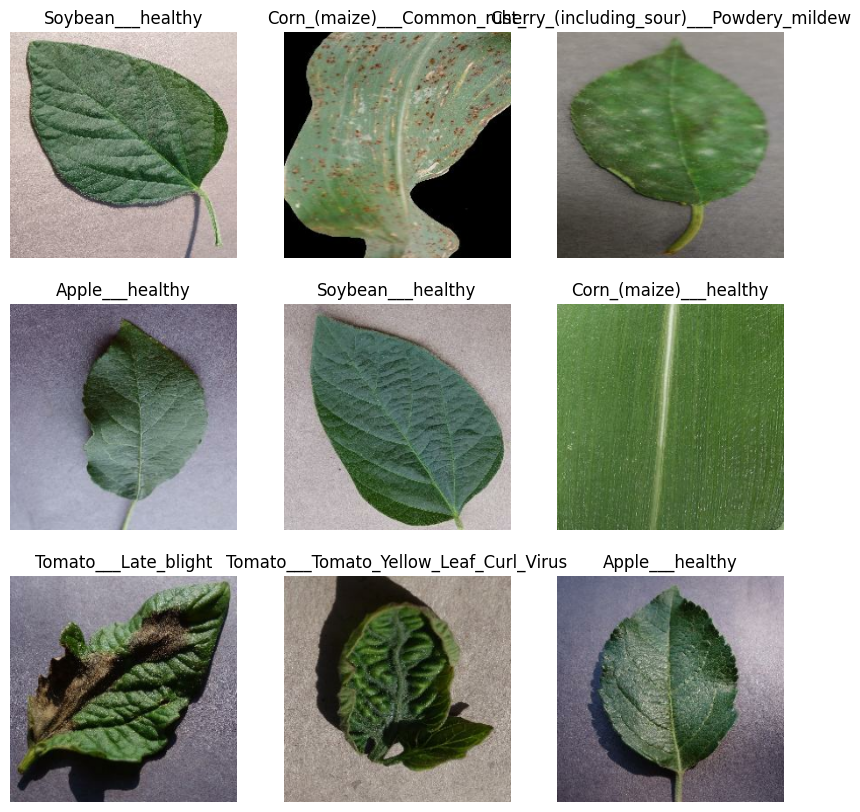

In [9]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

DATA_DIR = 'PlantVillage/train' #trainFolder

#load dataset
print("loading full dataset...")
full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,     #mix classes
    seed=123          #seed for shuffle
)

#60% train, 20% val, 20% test
total_batches = len(full_dataset)
train_size = int(0.6 * total_batches)
val_size = int(0.2 * total_batches)
test_size = int(0.2 * total_batches)

print(f"\n--- split statistics ---")
print(f"total batches: {total_batches}")
print(f"training batches: {train_size} (60%)")
print(f"validation batches: {val_size} (20%)")
print(f"testing batches: {test_size} (20%)")

train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
validation_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)
print("data split successfully!")


#visualize

class_names = full_dataset.class_names
print(f"\ntotal classes found: {len(class_names)}")
# print(class_names[:5])

#example batch check
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Build Your Model (Transfer Learning)**

*We use Transfer Learning with MobileNetV2. We freeze the pre-trained layers (the 'expert') and add our own classification head for the 38 plant diseases.*

In [10]:
IMG_SHAPE = IMAGE_SIZE + (3,) # (224, 224, 3) for RGB

#load MobileNetV2, but without its final "decision" layer (include_top=False)
#use 'imagenet' weights, which are the "expert" knowledge
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

#freeze the expert
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:

inputs = tf.keras.Input(shape=IMG_SHAPE)

#add the base_model (the expert)
#we set training=False so it always runs in inference mode
#critical detail for BatchNormalization layers
x = base_model(inputs, training=False)

#this layer "averages" all the features the expert found
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#"dropout" layer randomly turns off neurons to
#prevent overfitting
x = tf.keras.layers.Dropout(0.2)(x)

#final "decision" layer
#haslen(class_names) outputs
#'softmax' converts the outputs into probabilities for each class
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

#final model
model = tf.keras.Model(inputs, outputs)

In [12]:
#the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Train Your Model**

In [13]:
model.compile(
    optimizer='adam', #'adam' all-purpose optimizer
    loss='sparse_categorical_crossentropy', #labels are integers
    metrics=['accuracy']
)

In [14]:
#train for 10 epochs
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.4436 - loss: 2.0794 - val_accuracy: 0.7220 - val_loss: 0.9727
Epoch 2/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - accuracy: 0.7197 - loss: 0.9753 - val_accuracy: 0.7738 - val_loss: 0.7726
Epoch 3/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 69s 85ms/step - accuracy: 0.7622 - loss: 0.8101 - val_accuracy: 0.8007 - val_loss: 0.6742
Epoch 4/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 60s 74ms/step - accuracy: 0.7836 - loss: 0.7198 - val_accuracy: 0.8103 - val_loss: 0.6394
Epoch 5/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.7972 - loss: 0.6720 - val_accuracy: 0.8206 - val_loss: 0.6004
Epoch 6/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.8050 - loss: 0.6331 - val_accuracy: 0.8244 - val_loss: 0.5744
Epoch 7/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 60s 74ms/step - accuracy: 0.8134 - loss: 0.6065 - val_accuracy: 0.8175 - val_loss: 0.5750
Epoch 8/10
814/814 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.8254 - loss: 0.5752 - 

In [15]:

#save the entire model
model.save('plant_disease_model_60_20_20.keras')

print("model saved to plant_disease_model_60_20_20.keras")

Model saved to plant_disease_model_60_20_20.keras


**Evaluate & Demo (The "Proof of Concept")**

*Final Evaluation: We test the model on the held-out Test Set (20% of data) which the model has never been seen before.*

In [18]:
#

# 'test_dataset' which the model has NEVER seen.
print("evaluating on the test set (final exam)...")
test_results = model.evaluate(test_dataset)

print(f"\n--- FINAL RESULTS ---")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]*100:.2f}%")

Evaluating on the Test Set (Final Exam)...
273/273 ━━━━━━━━━━━━━━━━━━━━ 49s 72ms/step - accuracy: 0.8266 - loss: 0.5518

--- FINAL RESULTS ---
Test Loss: 0.5488
Test Accuracy: 83.04%


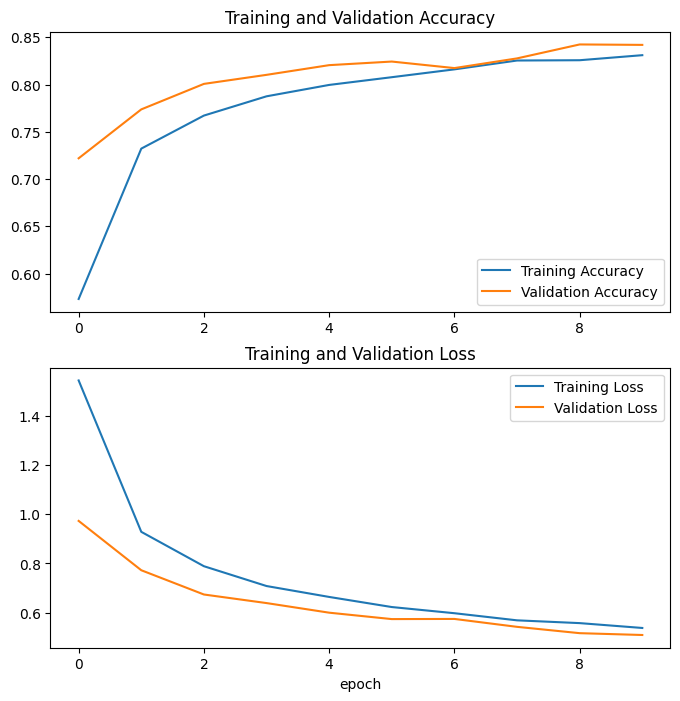

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



Save as back up

In [24]:
!ls /content


drive	     plant_disease_model_60_20_20.keras  plantvillage.zip
kaggle.json  PlantVillage			 sample_data


In [25]:
#save in Drive as backup
from google.colab import drive
drive.mount('/content/drive')

DESTINATION_FOLDER = '/content/drive/MyDrive/Foundational_AI_Project'

!mkdir -p "$DESTINATION_FOLDER"

!cp /content/plant_disease_model_60_20_20.keras "$DESTINATION_FOLDER/"
!cp /content/plantvillage.zip "$DESTINATION_FOLDER/"
!cp /content/kaggle.json "$DESTINATION_FOLDER/"

print(f"success! All files saved to: {DESTINATION_FOLDER}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Success! All files saved to: /content/drive/MyDrive/Foundational_AI_Project
